## 1. Importing Library

In [82]:
%pip install Sastrawi
import pandas as pd
import numpy as num
import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import word_tokenize
import string
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import pickle
nltk.download('punkt')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fazri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Data Understanding

In [83]:
train = pd.read_csv('train_data_restaurant.tsv', sep='\t', names=['ulasan', 'sentiment'])
train.head()

,ulasan,sentiment
0,Saya makan di sini dengan menggunakan voucher ...,negative
1,Mas indosat buat main game enemy has been slai...,negative
2,Trus sy percuma dong update no hp terbaru ke c...,negative
3,jika kita pilih dia maka akan ada lebih dari 3...,negative
4,Dikarenakan adik saya suka dengan restoran ini...,negative


In [84]:
print('data dimension: ', train.shape)

data dimension:  (1780, 2)


In [85]:
train.isnull().sum()

ulasan       0
sentiment    0
dtype: int64

In [86]:
print('duplicate: ', train.duplicated().sum())

duplicate:  0


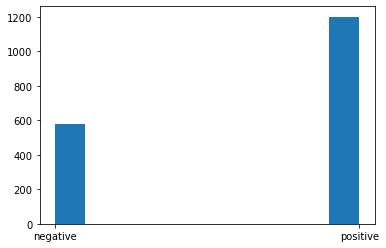

In [87]:
plt.hist(train.sentiment)
plt.show()

## 3. Preprocessing

In [88]:

class Preprocessor:
  def caseFolding(self, text):
    lowerCase = text.lower()
    numRemoved = re.sub(r"\d+", "", lowerCase)
    puncRemoved = numRemoved.translate(str.maketrans("", "", string.punctuation))
    return puncRemoved.strip()

  def stopWordRemoving(self, text):
    stopwordList = StopWordRemoverFactory().get_stop_words()
    result = list()
    tokens = word_tokenize(text)
    for token in tokens:
      if token not in stopwordList:
        result.append(token)
    return ' '.join(result)

  def stemming(self, text):
    stemmer = StemmerFactory().create_stemmer()
    return stemmer.stem(text)

  def filtering(self, text):
    result = self.stemming(self.stopWordRemoving(self.caseFolding(text)))
    result = result.replace('sy', '')
    result = result.replace('tp', 'tapi')
    result = result.replace('tdk', 'tidak')
    result = result.replace('tll', 'terlalu')
    result = result.replace('tidak bagus', 'jelek')
    result = result.replace('tidak jelek', 'bagus')
    result = result.replace('tidak kecewa', 'suka')
    result = result.replace('tidak suka', 'kecewa')
    result = result.replace('muas', 'puas')
    result = result.replace('tidak puas', 'kecewa')
    result = result.replace('tidak senang', 'kecewa')

    return result

In [89]:
preProc = Preprocessor()
pickle.dump(preProc, open('./preprocessors/pre.pkl', 'wb'))

In [90]:
train['ulasan_cleaned'] = train.ulasan.apply(preProc.filtering)
train.head()

,ulasan,sentiment,ulasan_cleaned
0,Saya makan di sini dengan menggunakan voucher ...,negative,makan sini guna voucher disdus paket nasi ayam...
1,Mas indosat buat main game enemy has been slai...,negative,mas indosat buat main game enemy has been slai...
2,Trus sy percuma dong update no hp terbaru ke c...,negative,trus percuma dong update no hp baru cs cab bn...
3,jika kita pilih dia maka akan ada lebih dari 3...,negative,pilih lebih kampung gusur
4,Dikarenakan adik saya suka dengan restoran ini...,negative,karena adik suka restoran akhir mampir sini aw...


In [91]:
X_train = train['ulasan_cleaned']
y_train = train['sentiment']

In [92]:
test = pd.read_csv('test_data_restaurant.tsv', sep='\t', names=['ulasan', 'sentiment'])
X_test = test['ulasan'].apply(preProc.filtering)
y_test = test['sentiment']

## 4. Labeling 

In [93]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

## 5. Vectorizing

In [94]:
vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([X_train, X_test]))
pickle.dump(vectorizer, open('./vectorizers/tfidf.pkl', 'wb'))

In [95]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## 6. Implement Model

In [96]:
model = SVC(kernel='rbf', C=100, gamma=0.01)
model.fit(X_train_vec, y_train)
pickle.dump(model, open('./models/svc.pkl', 'wb'))

## 7. Predict

In [97]:
y_pred = model.predict(X_test_vec)

## 8. Evaluating Model

### 8.1. Metrics evaluation

In [101]:
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ', recall_score(y_pred, y_test))
print('Precision: ', precision_score(y_pred, y_test))
print('F1 Score: ', f1_score(y_pred, y_test))

Accuracy:  0.8108108108108109
Recall:  0.8102189781021898
Precision:  0.925
F1 Score:  0.8638132295719844


In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.60      0.69        65
           1       0.81      0.93      0.86       120

    accuracy                           0.81       185
   macro avg       0.81      0.76      0.78       185
weighted avg       0.81      0.81      0.80       185



### 8.2. Confusion matrix

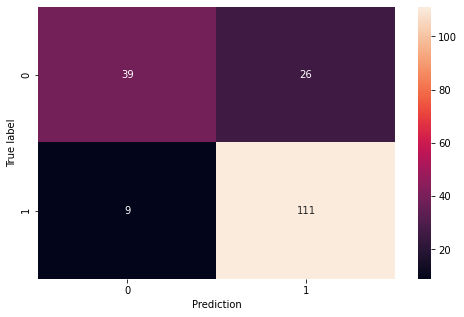

In [99]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Prediction")
plt.ylabel("True label")
plt.show()